## Bias correction for projected data

In this example, bias correction was done for projection data from V3 dataset using CMORPH

historical time period 2010 to 2015

projection time period 2040 to 2045

Selected regions: Changi Climate Station,East Coast Parkway,Paya Lebar Meteorological Station,Sembawang Meteorological Station,Tengah Meteorological Station

For evaluation purposes, V3-WMC was used as modelled and V3-SG was used to evlaution the performance of the corrected data. As we observed, WMC and SG are actually the same values so there is really nothing to evaluate. Based on the bias correction technique, the corrected projection data seems very high with 0.01% at >400 mm/h compared to 82 mm/h for projection.

100%|██████████| 1/1 [00:00<00:00, 200.01it/s]


Mean Absolute Error (Predicted vs Observed Future): 0.7743966233774596
Threshold values at different percentages:
Percentages:  [10, 25, 50, 75, 90, 95, 99, 99.9, 99.99]
Predicted thresholds: [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 14.67, 223.69, 426.27]
Observed Future thresholds: [0.00, 0.00, 0.00, 0.00, 0.00, 0.08, 8.26, 40.71, 83.20]
Model Future thresholds: [0.00, 0.00, 0.00, 0.00, 0.00, 0.08, 8.26, 40.71, 83.20]
Model Historical thresholds: [0.00, 0.00, 0.00, 0.00, 0.00, 0.18, 8.62, 40.49, 68.09]
Observed Historical thresholds: [0.00, 0.00, 0.00, 0.00, 0.00, 1.30, 6.04, 18.11, 34.61]


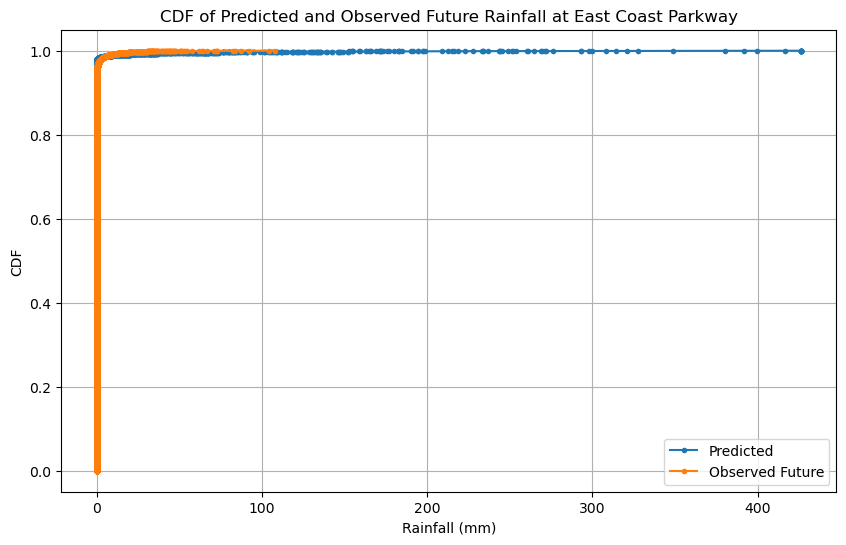

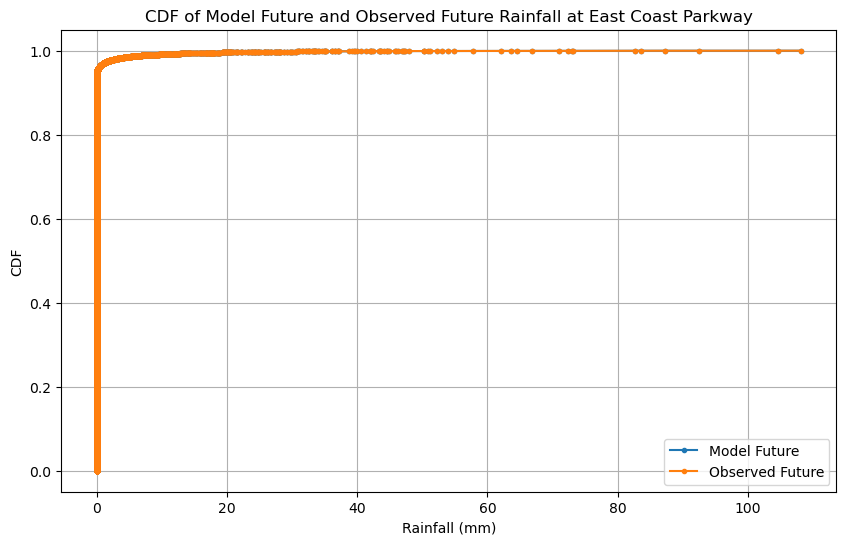

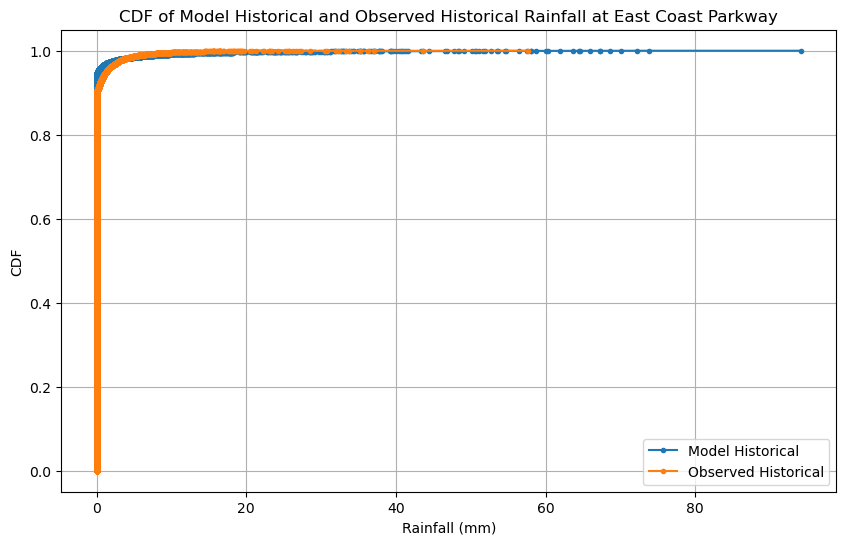

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import warnings
from ibicus.debias import QuantileMapping
from scipy.stats import kstest

warnings.filterwarnings("ignore")

# Load data
model_hist = pd.read_csv(r"C:\Users\Jun Wei\Desktop\rain analytics\Sample database\model_historical.csv")
model_future = pd.read_csv(r"C:\Users\Jun Wei\Desktop\rain analytics\Sample database\model_future.csv")
obs_hist = pd.read_csv(r"C:\Users\Jun Wei\Desktop\rain analytics\Sample database\Obs_historical.csv")
obs_future = pd.read_csv(r"C:\Users\Jun Wei\Desktop\rain analytics\Sample database\Obs_future.csv")

# Convert 'Datetime' to datetime type
model_hist["Datetime"] = pd.to_datetime(model_hist["Datetime"])
model_future["Datetime"] = pd.to_datetime(model_future["Datetime"])
obs_hist["Datetime"] = pd.to_datetime(obs_hist["Datetime"])
obs_future["Datetime"] = pd.to_datetime(obs_future["Datetime"])

# Define date range and location
start = '2010-01-01'
end = '2014-12-31'
location = "East Coast Parkway"

# Extract relevant data for the location
model_hist_location = model_hist[["Datetime", location]]
model_hist_location[location] *= 3600
model_future_location = model_future[["Datetime", location]]
model_future_location[location] *= 3600
obs_hist_location = obs_hist[["Datetime", location]]
obs_future_location = obs_future[["Datetime", location]]
obs_future_location[location] *= 3600

# Resample observation data to hourly intervals
obs_hist_location = obs_hist_location.set_index('Datetime').resample('1H').max().reset_index()
obs_future_location = obs_future_location.set_index('Datetime').resample('1H').max().reset_index()

# Convert the relevant column to numpy array and reshape
obs_hist_location_reshaped = obs_hist_location[location].values.reshape((-1, 1, 1))
obs_future_location_reshaped = obs_future_location[location].values.reshape((-1, 1, 1))

# Convert model data to numpy arrays and reshape
model_hist_location_reshaped = model_hist_location[location].values.reshape((-1, 1, 1))
model_future_location_reshaped = model_future_location[location].values.reshape((-1, 1, 1))

# Apply debiasing
debiaser = QuantileMapping.from_variable("pr")
pred = debiaser.apply(model_hist_location_reshaped, obs_hist_location_reshaped, model_future_location_reshaped)

# Flatten the arrays for MAE and KS test calculation
pred_flat = pred.flatten()
obs_future_flat = obs_future_location_reshaped.flatten()
obs_hist_flat = obs_hist_location_reshaped.flatten()
model_hist_flat = model_hist_location[location].values.flatten()
model_future_flat = model_future_location[location].values.flatten()

# Calculate and print MAE
mae_pred_obs = mean_absolute_error(pred_flat, obs_future_flat)
print(f"Mean Absolute Error (Predicted vs Observed Future): {mae_pred_obs}")

# Function to calculate CDF
def calculate_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Calculate CDF for predicted and observed future values
pred_sorted, pred_cdf = calculate_cdf(pred_flat)
obs_future_sorted, obs_future_cdf = calculate_cdf(obs_future_flat)

# Perform KS test for predicted vs observed future values
ks_stat_pred_obs, p_value_pred_obs = kstest(pred_flat, obs_future_flat)
#print(f"KS Statistic (Predicted vs Observed Future): {ks_stat_pred_obs}")
#print(f"P-value (Predicted vs Observed Future): {p_value_pred_obs}")

# Calculate and plot CDF for model_future vs obs_future
model_future_sorted, model_future_cdf = calculate_cdf(model_future_flat)
obs_future_sorted, obs_future_cdf = calculate_cdf(obs_future_flat)

# Perform KS test for model_future vs obs_future values
ks_stat_model_obs, p_value_model_obs = kstest(model_future_flat, obs_future_flat)
#print(f"KS Statistic (Model Future vs Observed Future): {ks_stat_model_obs}")
#print(f"P-value (Model Future vs Observed Future): {p_value_model_obs}")

# Calculate and print MAE for model_future vs obs_future
mae_model_obs = mean_absolute_error(model_future_flat, obs_future_flat)
#print(f"Mean Absolute Error (Model Future vs Observed Future): {mae_model_obs}")

# Calculate threshold values for different percentages
percentages = [10, 25, 50, 75, 90, 95, 99, 99.9, 99.99]
thresholds = {
    "Predicted": np.percentile(pred_flat, percentages),
    "Observed Future": np.percentile(obs_future_flat, percentages),
    "Model Future": np.percentile(model_future_flat, percentages),
    "Model Historical": np.percentile(model_hist_flat, percentages),
    "Observed Historical": np.percentile(obs_hist_flat, percentages),
}

print("Threshold values at different percentages:")
print("Percentages: ", percentages)
for key, value in thresholds.items():
    formatted_values = ", ".join([f"{v:.2f}" for v in value])
    print(f"{key} thresholds: [{formatted_values}]")


'''
# Perform KS test for model_hist vs obs_hist values
ks_stat_model_hist_obs_hist, p_value_model_hist_obs_hist = kstest(model_hist_flat, obs_hist_flat)
print(f"KS Statistic (Model Historical vs Observed Historical): {ks_stat_model_hist_obs_hist}")
print(f"P-value (Model Historical vs Observed Historical): {p_value_model_hist_obs_hist}")

# Calculate and print MAE for model_hist vs obs_hist
mae_model_hist_obs_hist = mean_absolute_error(model_hist_flat, obs_hist_flat)
print(f"Mean Absolute Error (Model Historical vs Observed Historical): {mae_model_hist_obs_hist}")
'''
# Calculate and plot CDF for model_hist vs obs_hist
model_hist_sorted, model_hist_cdf = calculate_cdf(model_hist_flat)
obs_hist_sorted, obs_hist_cdf = calculate_cdf(obs_hist_flat)

# Plot CDF
plt.figure(figsize=(10, 6))
plt.plot(pred_sorted, pred_cdf, label='Predicted', linestyle='-', marker='.')
plt.plot(obs_future_sorted, obs_future_cdf, label='Observed Future', linestyle='-', marker='.')
plt.xlabel('Rainfall (mm)')
plt.ylabel('CDF')
plt.title(f'CDF of Predicted and Observed Future Rainfall at {location}')
plt.legend()
plt.grid(True)
plt.show()

# Plot CDF for model_future vs obs_future
plt.figure(figsize=(10, 6))
plt.plot(model_future_sorted, model_future_cdf, label='Model Future', linestyle='-', marker='.')
plt.plot(obs_future_sorted, obs_future_cdf, label='Observed Future', linestyle='-', marker='.')
plt.xlabel('Rainfall (mm)')
plt.ylabel('CDF')
plt.title(f'CDF of Model Future and Observed Future Rainfall at {location}')
plt.legend()
plt.grid(True)
plt.show()

# Plot CDF for model_hist vs obs_hist
plt.figure(figsize=(10, 6))
plt.plot(model_hist_sorted, model_hist_cdf, label='Model Historical', linestyle='-', marker='.')
plt.plot(obs_hist_sorted, obs_hist_cdf, label='Observed Historical', linestyle='-', marker='.')
plt.xlabel('Rainfall (mm)')
plt.ylabel('CDF')
plt.title(f'CDF of Model Historical and Observed Historical Rainfall at {location}')
plt.legend()
plt.grid(True)
plt.show()
